                   t1         sl         pt
2025-01-01 2025-01-21 2025-01-19 2025-01-04
2025-01-11 2025-01-31 2025-01-14        NaT
2025-01-21 2025-02-10 2025-01-25        NaT
2025-01-31 2025-02-20 2025-02-08        NaT
2025-02-10 2025-03-02 2025-02-15        NaT
2025-02-20 2025-03-12        NaT 2025-03-10
2025-03-02 2025-03-22 2025-03-05 2025-03-13
2025-03-12 2025-04-01        NaT 2025-03-15
2025-03-22 2025-04-11        NaT 2025-04-02
2025-04-01 2025-04-21        NaT        NaT


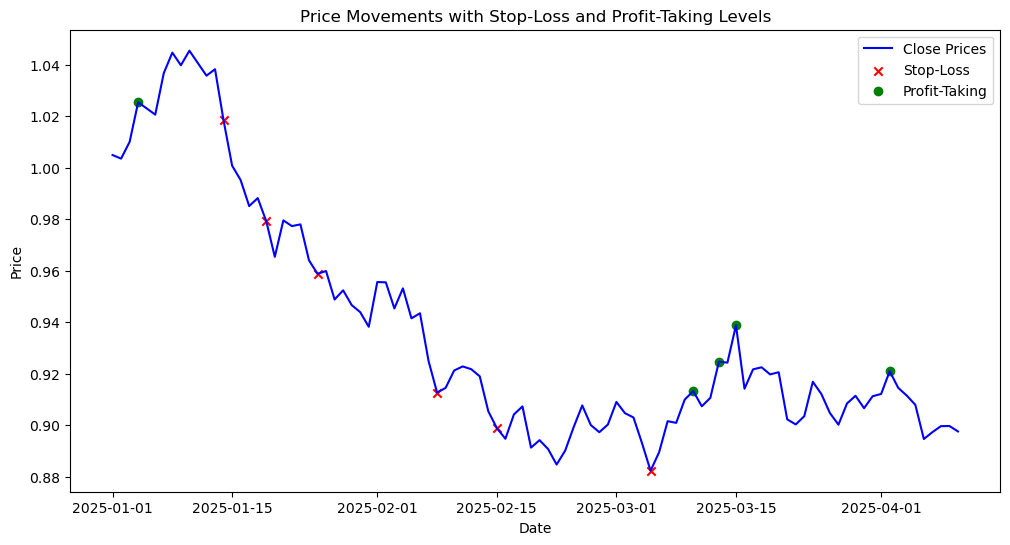

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def applyPtSlOnT1(close, events, ptSl, molecule):
    """
    Apply stop loss/profit taking, if it occurs before t1 (end of event).

    Parameters:
        close (pd.Series): Closing prices indexed by timestamps.
        events (pd.DataFrame): Events dataframe with columns ['t1', 'trgt', 'side'].
        ptSl (tuple): Tuple (profit-taking multiplier, stop-loss multiplier).
        molecule (list): Subset of event indices to process.

    Returns:
        pd.DataFrame: Updated events DataFrame with stop-loss ('sl') and profit-taking ('pt') timestamps.
    """
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)

    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events_.index)  # NaNs

    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events_.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # Path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # Path returns

        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # Earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # Earliest profit taking

    return out

# Generate synthetic close prices
np.random.seed(42)
dates = pd.date_range(start="2025-01-01", periods=100, freq='D')
close_prices = pd.Series(np.cumprod(1 + np.random.randn(100) * 0.01), index=dates)

# Create synthetic events
event_indices = dates[::10]  # Every 10 days
events = pd.DataFrame(index=event_indices)
events['t1'] = events.index + pd.Timedelta(days=20)  # Horizon of 20 days
events['trgt'] = 0.02  # 2% threshold
events['side'] = 1  # Long positions

# Apply function
ptSl = (1, 1)  # Profit-taking and stop-loss at 2%
molecule = events.index  # Process all events

result = applyPtSlOnT1(close_prices, events, ptSl, molecule)
print(result)

# Plot close prices and barriers
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Close Prices', color='blue')
plt.scatter(result['sl'].dropna(), close_prices[result['sl'].dropna()], color='red', marker='x', label='Stop-Loss')
plt.scatter(result['pt'].dropna(), close_prices[result['pt'].dropna()], color='green', marker='o', label='Profit-Taking')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Movements with Stop-Loss and Profit-Taking Levels')
plt.show()

